In [1]:
# Following unix command was executed to generate input file 
# cat merged_gene_SNP_ATAC.txt merged_gene_SNP_functionalRegion.txt > merged_gene_SNP.txt

In [2]:
# import packages
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
def writeGenes2List(filepath, index):
    '''
    Take in a file and write the gene symbols of genes expressed in the non-neural ectoderm to a list.
    
    @filepath   file path to file containing a list of gene symbols of interest
    @index      index position of the gene symbols in the file
    @return     list of gene symbols
    '''
    genes = []
    with open(filepath, 'r') as file:
        genes = []
        for line in file:
            line = line.strip('\r\n').split('\t')
            genes.append(line[index])
    file.close()
    return(genes)

def writeLoops2List(filepath, resolution, FC_cutoff, FDR_cutoff):
    '''
    Take in a file and write loop coordinates to a list.
    
    @filepath   file path to the file containing the loop coordinates of interest
    @resolution resolution of the loops
    @FC_cutoff  cutoff value for the FC of the loops to include
    @FDR_cutoff cutoff value for the FDR of the loops to include
    @return     list of loop coordinates
    '''
    loop_list = []
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip('\r\n').split('\t')
            loop, FC, FDR = (line[0], str(int(int(line[1])+resolution/2)),\
                             str(int(int(line[4])+resolution/2))), abs(float(line[7])), float(line[11])
            if FC > FC_cutoff and FDR < FDR_cutoff:
                loop_list.append(loop)
    file.close()
    return(loop_list)

def writeLoops2List_v2(filepath, FC_cutoff, FDR_cutoff):
    '''
    Take in a file and write loop coordinates to a list.
    
    @filepath   file path to the file containing the loop coordinates of interest
    @resolution resolution of the loops
    @FC_cutoff  cutoff value for the FC of the loops to include
    @FDR_cutoff cutoff value for the FDR of the loops to include
    @return     list of loop coordinates
    '''
    loop_list = []
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip('\r\n').split('\t')
            loop, FC, FDR = tuple(line[0:3]), abs(float(line[4])), float(line[8])
            if FC > FC_cutoff and FDR < FDR_cutoff:
                loop_list.append(loop)
    file.close()
    return(loop_list)

def writeFile2List(filepath):
    '''
    Take in a file and write lines to a list.
    
    @filepath   file path to file of interest
    @return     return list of lines in the file
    '''
    file_list = []
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip('\r\n').split('\t')
            file_list.append(line)
    file.close()
    return(file_list)

def write2dict(key, value, dictionary):
    '''
    Writes a key and value to a list in a dictionary in which the value is a list of values.
    
    @key          key
    @value        value to be added to a list
    @dictionary   dictionary to which the key, value pair will be added
    @return       updated dictionary
    '''
    if key in dictionary.keys() and value not in dictionary[key]:
        dictionary[key].append(value)
    elif key not in dictionary.keys():
        dictionary[key] = [value]
    return(dictionary)

def determine_node_outline_color(dictionary, gene, gene_list1, gene_list2):
    '''
    Based off of the functional information known about a given gene write the node outline
    color to a dictionary in which the gene is the key and the color is the value.
    
    @dictionary   dictionary recording the color of node outline for each node
    @gene         gene node of interest
    @gene_list1   list of genes of functional interest (p63-dep)
    @gene_list2   list of genes of functional interest (ap2a-dep)
    @return       updated dictionary
    '''
    if gene in gene_list1:
        if gene in gene_list2:
            dictionary[gene] = 'lightseagreen'  # p63-dep and ap2a-dep gene
        else:
            dictionary[gene] = 'seagreen'  # p63-dep gene
    elif gene in gene_list2:
        dictionary[gene] = 'royalblue'  # ap2a-dep gene
    else:
        dictionary[gene] = 'black'  # not p63-dep nor ap2a-dep gene
    return(dictionary)

def determine_node_shape(dictionary, gene, gene_list):
    '''
    Based off of functional information specify the node shape for a provided node in a
    dictionary with the node as the key and the shape as the value.
    
    @dictionary   dictionary recording the shape of each node
    @gene         gene node of interest
    @gene_list    list of genes of functional interest (mor-dep genes)
    @return       updated dictionary
    '''
    if gene in gene_list:
            dictionary[gene] = '^'  # mor-dep gene
    else:
        dictionary[gene] = 'o'  # not mor-dep gene
    return(dictionary)

def determine_edge_color(contact, loop_list1, loop_list2, loop_list3):
    '''
    Determine if a given contact is ap2a-dep, p63-dep, and/or mor-dep and
    return the appropriate associated color.
    
    @contact      loop to be queried
    @loop_list1   list of ap2a-dep loops
    @loop_list2   list of p63-dep loops
    @loop_list3   list of mor-dep loops
    @return       color associated with the loop dependecies
    '''
    if contact in loop_list1:
        if contact in loop_list2:
            if contact in loop_list3:
                return('cadetblue')  # ap2a-dep, p63-dep, mor-dep loop
            else:
                return('lightseagreen')  # ap2a-dep, p63-dep
        else:
            if contact in loop_list3:
                return('lightsteelblue')  # ap2a-dep, mor-dep loop
            else:
                return('royalblue')  # ap2a-dep
    elif contact in loop_list2:
        if contact in loop_list3:
            return('darkseagreen')  # p63-dep, mor-dep
        else:
            return('seagreen')  # p63-dep loop
    elif contact in loop_list3:
        return('silver')  # mor-dep loop
    return('black')  # no dependence
                

def record_edge_info(value, key, edge_width_dictionary, edge_color_dictionary, loop,\
                     loop_list1, loop_list2, loop_list3):
    '''
    Write the maximum connectivity value for chromatin loop between gene and SNP.
    
    @value        connectivity value for a chromatin loop connecting gene and SNP
    @key          gene-SNP edge
    @edge_width_dictionary   dictionary containing maximum connectivity value for each edge
    @edge_color_dictionary   dictionary containing the edge color based off of functional loop info
    @loop         loop coordinates
    @loop_list    list of loops of functional interest (ap2a-dep)
    @return       updated dictionaries (edge_with_dictionary, edge_color_dictionary)
    '''
    if key in edge_width_dictionary and value > edge_width_dictionary[key]:
        edge_width_dictionary[key] = value
        edge_color_dictionary[key] = determine_edge_color(loop, loop_list1, loop_list2, loop_list3)
    elif key not in edge_width_dictionary:
        edge_width_dictionary[key] = value
        edge_color_dictionary[key] = determine_edge_color(loop, loop_list1, loop_list2, loop_list3)
    return(edge_width_dictionary, edge_color_dictionary)


def defineNodeType(dictionary):
    '''
    Convert node type to a single string. If there is only one type of regulatory element assigned
    to a SNP, then assign it as that 'type'. Otherwise designate the node as type 'multiple'.
    
    @dictionary   dictionary containing all regulatory elements in which a SNP is contained
    @return       dictionary with the type of a node as a single string value
    '''
    final_node_type_dict = {}
    for key, value in dictionary.items():
        if len(value) == 1:
            final_node_type_dict[key] = value[0]
        else:
            final_node_type_dict[key] = 'multiple'
    return(final_node_type_dict)

def buildColorMap(G):
    '''
    Specify the node color based off of the node-type attribute, which specifies if the node
    is a gene or the type of regulatory element in which a SNP is contained. Contains this
    information in a color_map with the node as the key and the value as the color.
    
    @G        networkx graph containing nodes of interest
    @return   color map with the node as the key and the color as the value
    '''
    node_types = nx.get_node_attributes(G,'type')
    color_map = {}
    for n in G.nodes():
    # loop through nodes; color compounds red and targets yellow; specify target names
        if node_types[n] == 'ATAC':
            color_map[n] = 'red'
        else:
            print(node_types[n])
            color_map[n] = 'black'
    return(color_map)

In [4]:
#def main():
# write information on non-neural ectoderm gene expression to lists
expressed_genes = writeGenes2List('H9_d7_expressed_genes_list.txt', 0)
p63_dep_genes = writeGenes2List('1.5FC_d7p63WTvsd7p63KO_p0.05_proteinCodingGenes.bed', 3)
ap2a_dep_genes = writeGenes2List('ALL-2A-dep_genes.bed', 0)
mor_dep_genes = writeGenes2List('DESeq2_1.5FC_padj0.05_WTD0_vs_WTD7_genes.bed', 3)

# write information on non-neural ectoderm loops to lists
ap2a_dep_loops = writeLoops2List('ID_EdgeR_results_All_d72AKOvsd7p63WT_ALL.bed', 10000, 0.589463, 0.05)
p63_dep_loops = writeLoops2List_v2('EdgeR_results_All_d7p63KOvsd7p63WT_contact_position.txt', 0.589463, 0.05)
mor_dep_loops = writeLoops2List_v2('EdgeR_results_All_d7p63WTvsd0_contact_position.txt', 0.589463, 0.05)

# write SNP_gene_regulatoryElement trios to a list
trios = writeFile2List("all_trios.txt") # See unix command at top

# define sets and dictionaries
nodes = set()
edges = set()
SNPs = set()
genes = set()
connectivity_dict = {}
SNP_dis_dict = {}
RE_dict = {}
group_dict = {}
TF_dep_dict = {}
shape_dict = {}
edge_color_dict = {}

# loop over trios and store node, edges, and functional informations to sets and dictionaries
for line in trios:
    enhancer, gene, SNP, MAF, connectivity = line[:5]
    if gene in expressed_genes:
        SNP_pos = int(line[9])
        SNP_dis = max([abs(SNP_pos-int(line[6])), abs(SNP_pos-int(line[7]))])
        loop_coord = tuple(line[14:])
        nodes.add(SNP)
        nodes.add(gene)
        edges.add((SNP, gene))
        SNPs.add(SNP)
        genes.add(gene)
        RE_dict = write2dict(SNP, enhancer, RE_dict)
        RE_dict[gene] = ['gene']
        group_dict[gene] = 'gene'
        group_dict[SNP] = 'SNP'
        connectivity_dict, edge_color_dict = record_edge_info(int(connectivity), (SNP, gene), connectivity_dict,\
                                             edge_color_dict, loop_coord, ap2a_dep_loops, p63_dep_loops, mor_dep_loops)
        SNP_dis_dict[(SNP, gene)] = SNP_dis
        TF_dep_dict = determine_node_outline_color(TF_dep_dict, gene, p63_dep_genes, ap2a_dep_genes)
        TF_dep_dict[SNP] = 'black'
        shape_dict = determine_node_shape(shape_dict, gene, mor_dep_genes)
        shape_dict[SNP] = 's'

node_type_dict = defineNodeType(RE_dict)
nodes = list(nodes)
edges = list(edges)
SNPs = list(SNPs)
genes = list(genes)
print(edges[:5])
print('There are '+str(len(nodes))+ ' nodes')
print('There are '+str(len(edges)) + ' edges')
print('There are ' + str(len(SNPs)) + ' SNPs')
print('There are ' + str(len(genes)) + ' genes')

[('rs4331889', 'MCC'), ('rs6996860', 'DDHD2'), ('rs3801807', 'HOXA10-HOXA9'), ('rs76145088', 'C1orf74'), ('rs72741048', 'TRAF3IP3')]
There are 299 nodes
There are 487 edges
There are 190 SNPs
There are 109 genes


In [5]:
'''
Specify the following about the graph
    - SNP node color based off of associated binding motif
    - gene node shape off of if it is morphogen-dependent or not
    - gene node outline by if it's p63 and/or ap2a-dependent
    - edge color by if it's ap2a-dependent
    - edge distance by linear distance
    - edge width by connectivity strength
'''  
# construct initial network
G=nx.Graph()
G.add_nodes_from(nodes)
for edge in edges:
    G.add_edge(*edge, length=SNP_dis_dict[edge], weight=connectivity_dict[edge]/20, color=edge_color_dict[edge])
print(G.number_of_nodes())
print(G.number_of_edges())
nx.set_node_attributes(G, name = 'regulatory_elements', values = RE_dict)
nx.set_node_attributes(G, name = 'type', values = node_type_dict)
nx.set_node_attributes(G, name = 'group', values = node_type_dict)
nx.set_edge_attributes(G, name = 'connectivity', values = connectivity_dict)
nx.set_edge_attributes(G, name = 'distance', values = SNP_dis_dict)

299
487


In [6]:
# print gene lists by components
count = 0
for c in sorted(nx.connected_components(G), key=len, reverse=True):
    print('Genes in component '+str(count)+':')
    c = list(c)
    sub_nodes = list(nx.node_connected_component(G, c[0]))
    S = G.subgraph(sub_nodes)
    for n in S.nodes():
        if n.startswith('rs'):
            print(n)
    print('\n')
    print('\n')
    count += 1

Genes in component 0:
rs2712248
rs3801844
rs2465264
rs4722641
rs12534901
rs2462906
rs3801805
rs2712245
rs2693662
rs73069539
rs3801831
rs2462904
rs73067456
rs73069540
rs17376018
rs2428431
rs34725546
rs17315334
rs17323934
rs3801807




Genes in component 1:
rs12678205
rs60558877
rs3824288
rs6996860
rs72630609
rs77263158
rs13317
rs1149
rs2270376
rs55962869
rs72630624




Genes in component 2:
rs10939672
rs10939671
rs4318649
rs2240722
rs6449217
rs6829727
rs2240721
rs4543113
rs3796839
rs2240720
rs4318650
rs2240724
rs6820188




Genes in component 3:
rs7814692
rs3913555
rs11203927
rs12718384
rs3913556
rs11996792
rs11203926
rs11987695
rs12718385
rs393842
rs7009476
rs5889752
rs1847154




Genes in component 4:
rs1688782
rs6440967
rs793469
rs28503408
rs62283523
rs16841874
rs793474
rs62285473
rs201155810
rs34922392
rs11711935




Genes in component 5:
rs3138490
rs3138507
rs2031968
rs8252
rs3138486
rs3138488
rs3138493
rs3138489
rs3138503
rs10120108
rs3138499




Genes in component 6:
rs772920
rs7

In [7]:
# print SNP lists by components
count = 0
for c in sorted(nx.connected_components(G), key=len, reverse=True):
    print('Genes in component '+str(count)+':')
    c = list(c)
    sub_nodes = list(nx.node_connected_component(G, c[0]))
    S = G.subgraph(sub_nodes)
    for n in S.nodes():
        if n.startswith('rs') == False:
            print(n)
    print('\n')
    print('\n')
    count += 1

Genes in component 0:
HOXA10-HOXA9
HOXA1
HOXA7
HOXA5
HOXA6
HOXA2
HOXA3
HOXA9
SKAP2
HOXA4




Genes in component 1:
LETM2
RAB11FIP1
PLPP5
ADGRA2
PROSC
BAG4
FGFR1
C8orf86
WHSC1L1
DDHD2
LSM1
BRF2




Genes in component 2:
SLC2A9
DRD5
WDR1




Genes in component 3:
PDGFRL
SLC7A2
MTMR7




Genes in component 4:
CMSS1
FILIP1L
TBC1D23
NIT2




Genes in component 5:
SYK




Genes in component 6:
IKZF4
RPS26
GDF11
RAB5B
PMEL
SUOX
CDK2




Genes in component 7:
ARID3B
CLK3
SEMA7A
UBL7
CYP11A1




Genes in component 8:
TRAF3IP3
C1orf74
IRF6




Genes in component 9:
DIEXF




Genes in component 10:
DCP2
MCC
YTHDC2




Genes in component 11:
TFAP2A




Genes in component 12:
KLF11




Genes in component 13:
WNT9B
WNT3




Genes in component 14:
SERTAD4
SYT14




Genes in component 15:
MYCN
DDX1
FAM49A




Genes in component 16:
SLC25A21
PAX9
NKX2-8




Genes in component 17:
COTL1




Genes in component 18:
TP63
TPRG1




Genes in component 19:
PHEX




Genes in component 20:
SPRY2




Genes in co

In [8]:
def buildAttributeMap(nodes, dictionary):
    attributeMap = []
    for n in nodes:
        attributeMap.append(dictionary[n])
    return(attributeMap)

def plotCentrality(G, node_bc, save_fig=False):
    color_map = []
    color_key = {}
    list_genes = []
    count_c = 0
    for n in G.nodes():
        color_map.append(n)
        color_key[n] = node_bc[n]
        if n.startswith('rs'):
            continue
        else:
            list_genes.append(n)
    for c in sorted(nx.connected_components(G), key=len, reverse=True):
        c = list(c)
        sub_nodes = list(nx.node_connected_component(G, c[0]))
        S = G.subgraph(sub_nodes)
        dict_relabel_subset = {}
        for n in S.nodes():
            if n in list_genes:
                dict_relabel_subset[n] = n
        color_map = buildAttributeMap(S.nodes(), color_key)
        fig, ax = plt.subplots()
        minima = min(color_map)
        maxima = max(color_map)
        norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima)
        cmap=cm.viridis
        mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        mapper.set_array([])
        fig.colorbar(mapper)
        pos=nx.spring_layout(S, seed=999)
        nx.draw(S, pos=pos, cmap=plt.get_cmap('viridis'), node_color=color_map, node_size=750)
        nx.draw_networkx_edges(S, pos=pos, with_labels=False)
        nx.draw_networkx_labels(S, pos, dict_relabel_subset, font_size=10)
        nx.draw_networkx_edges(S, pos=pos)
        if save_fig:
            plt.savefig('CFD_WTd7_cohesin_closeness_centrality_componenet_' + str(count_c) + '.pdf')
        count_c += 1
        plt.axis('off')
        plt.show()

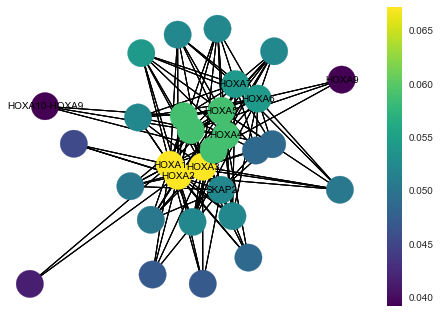

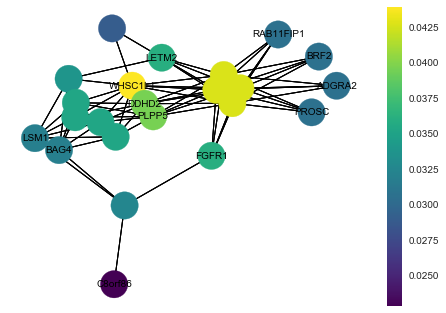

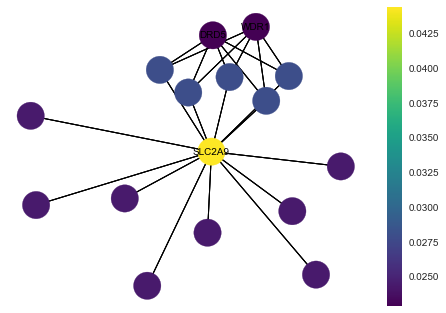

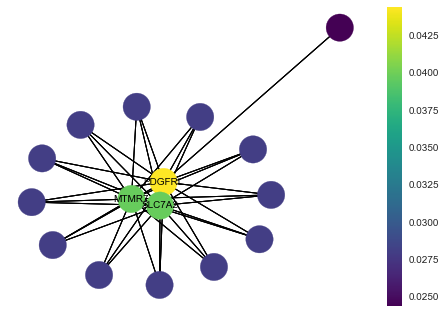

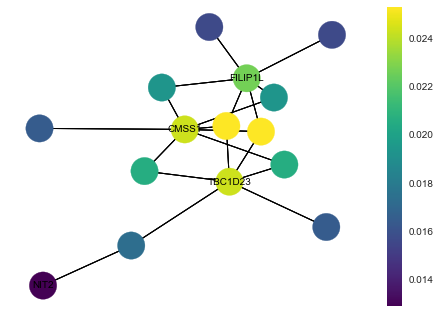

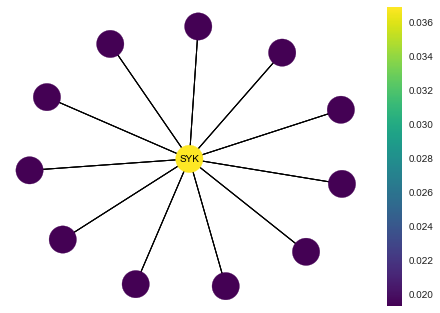

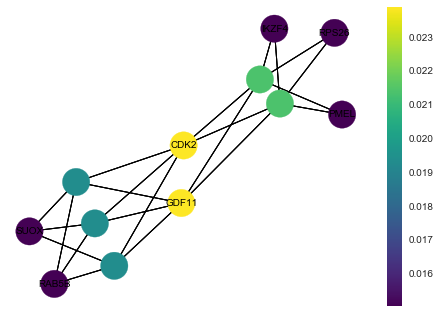

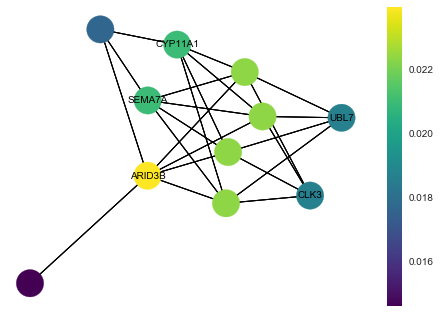

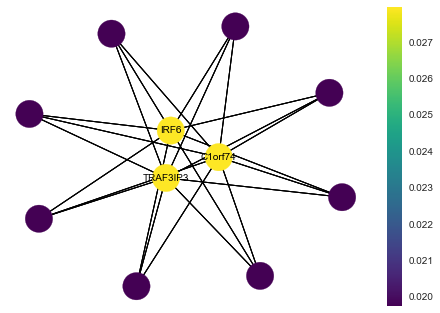

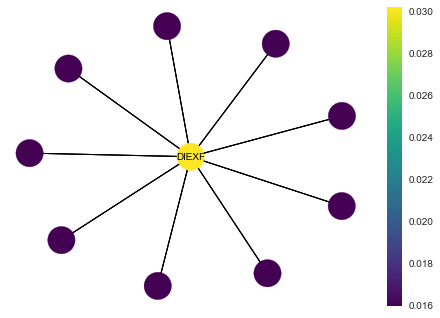

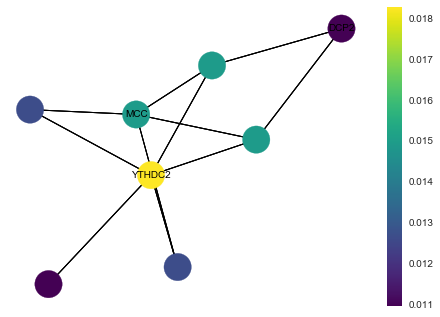

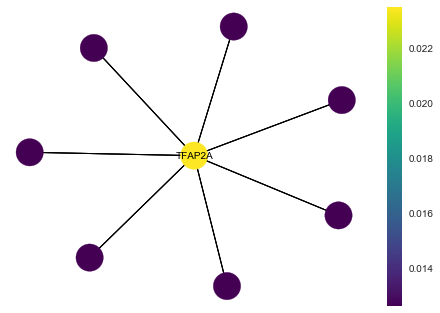

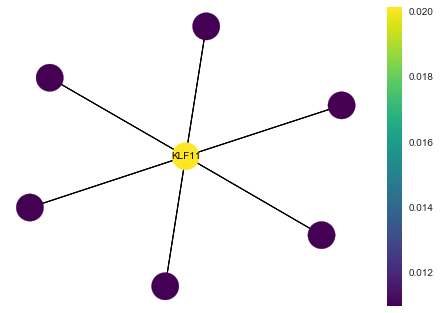

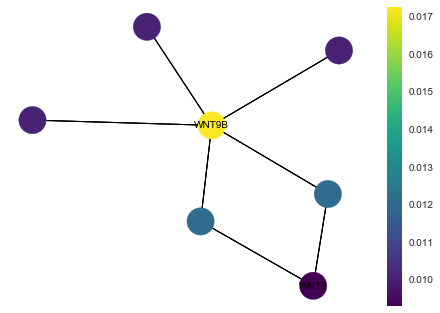

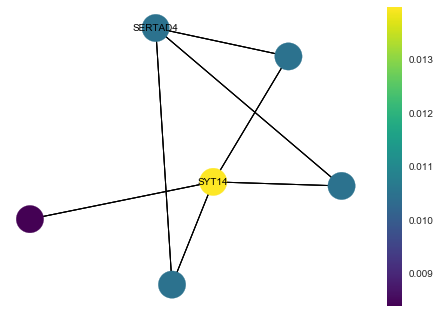

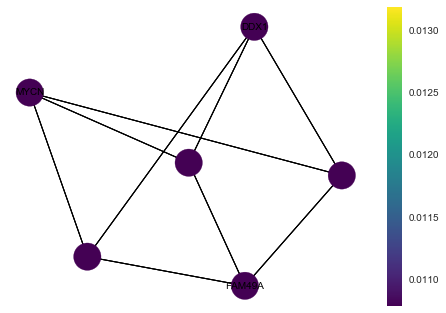

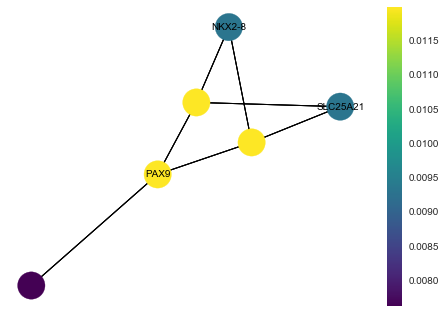

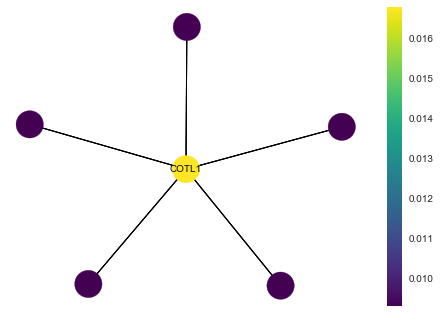

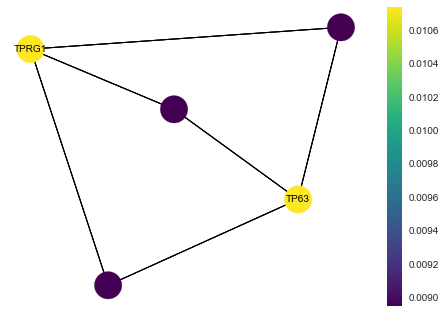

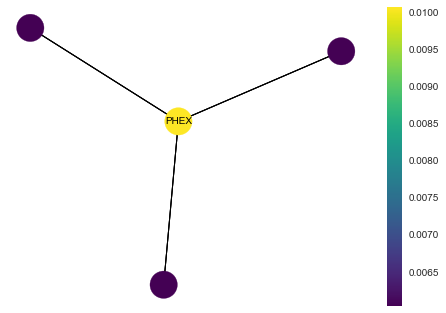

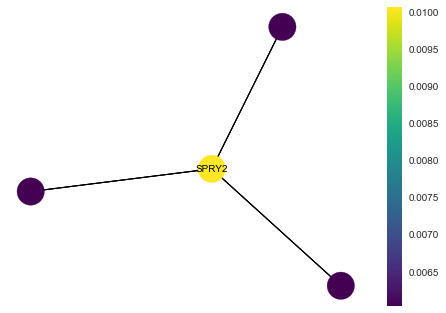

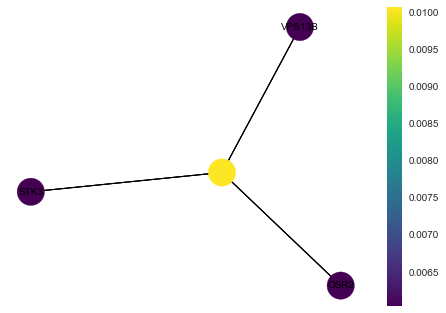

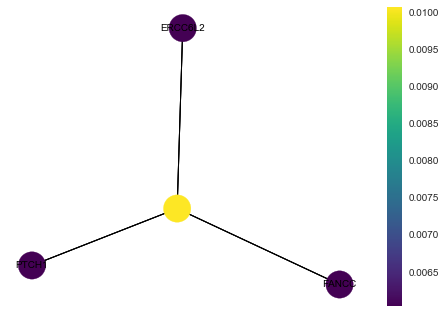

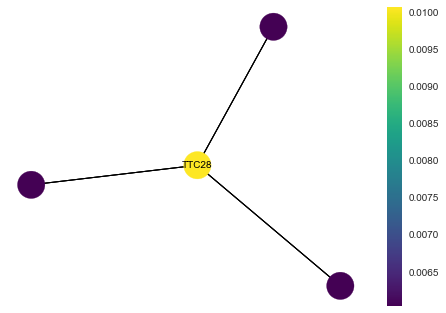

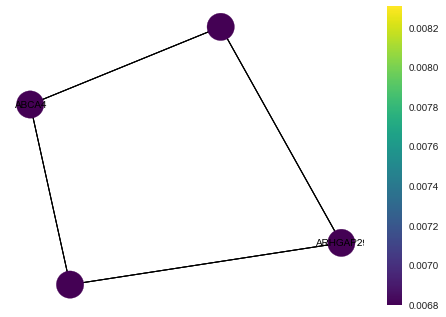

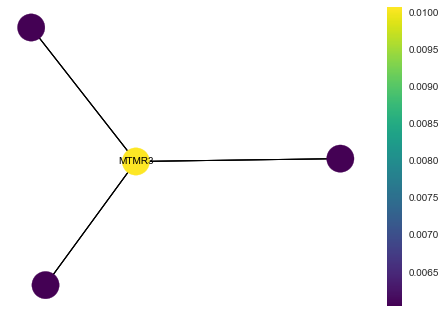

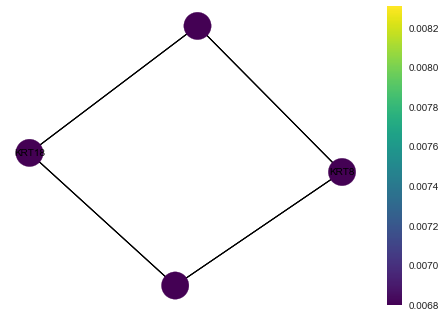

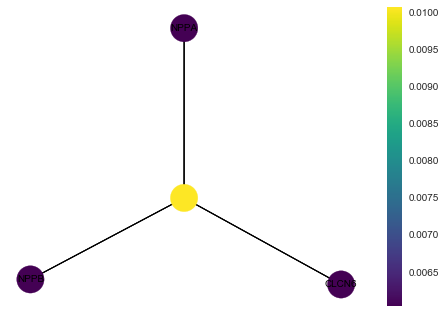

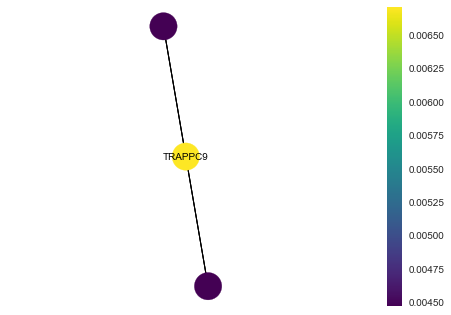

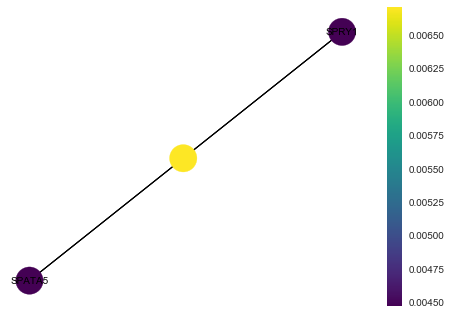

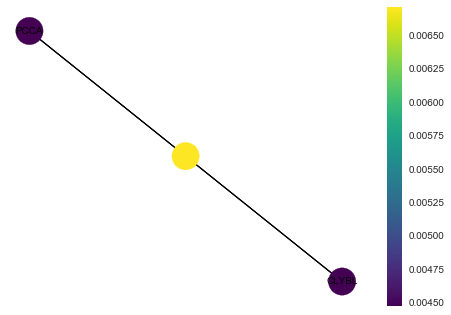

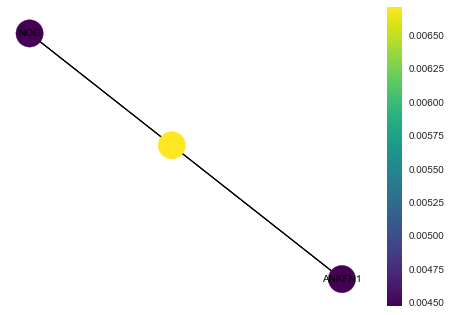

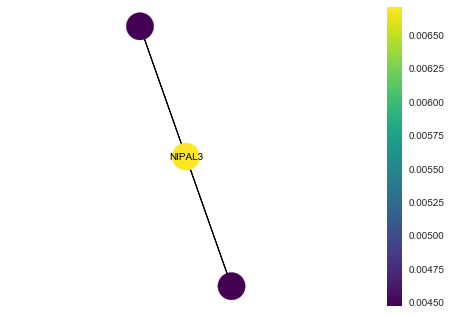

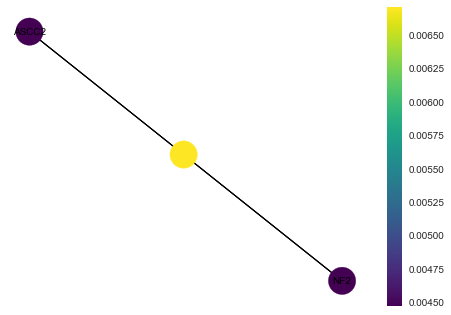

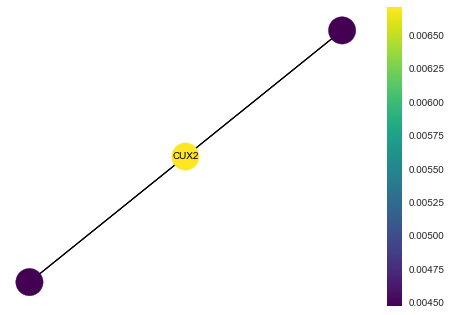

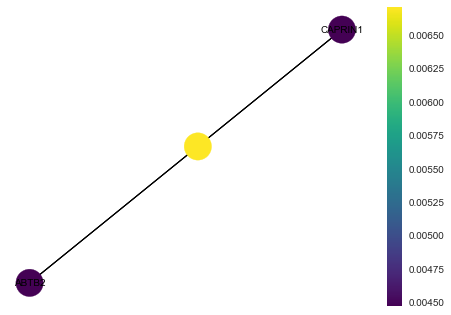

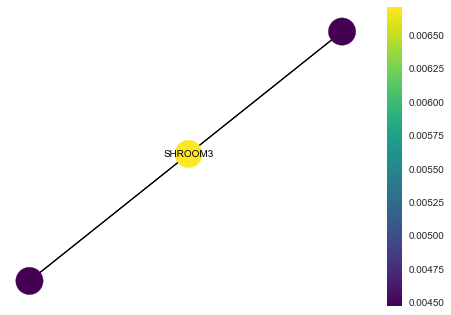

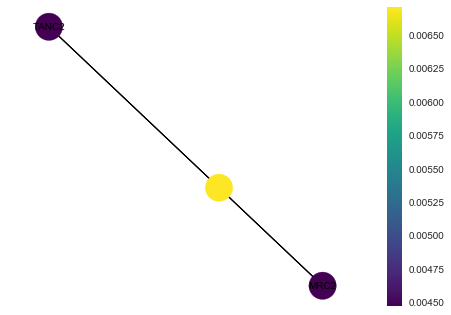

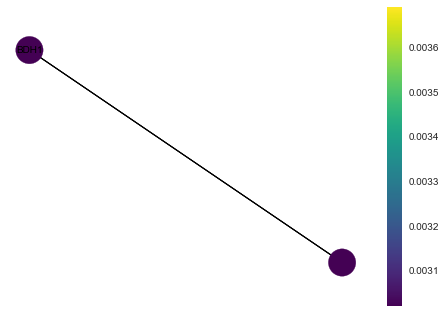

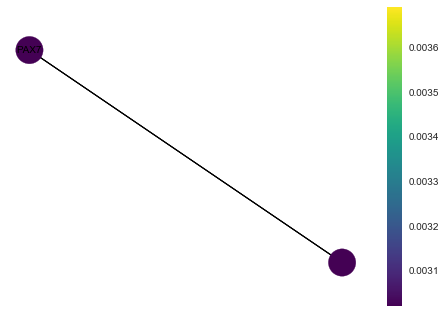

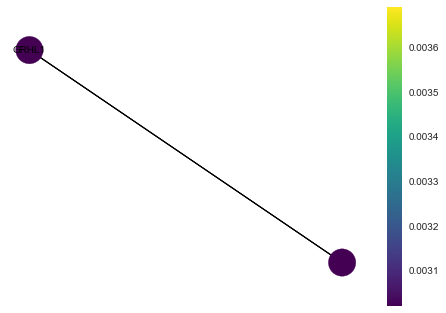

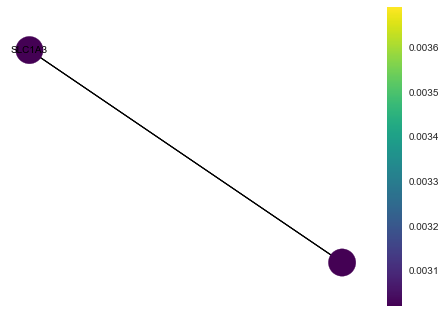

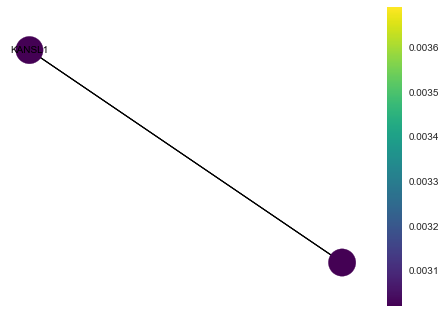

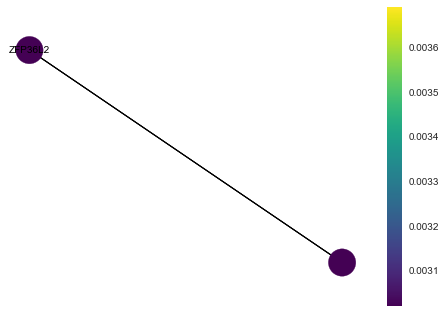

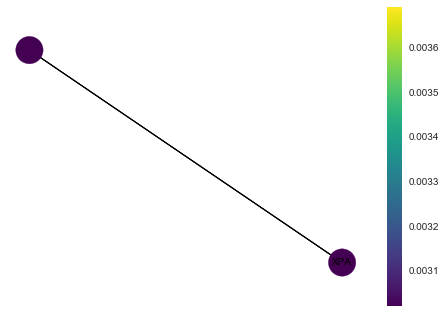

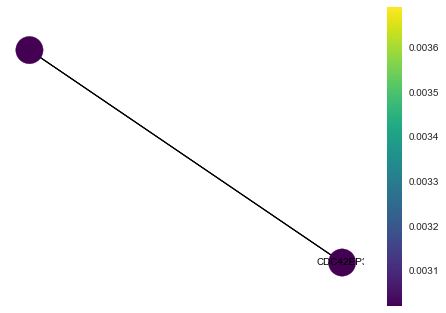

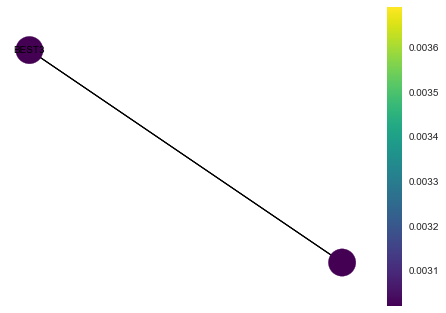

In [9]:
plotCentrality(G, nx.closeness_centrality(G), save_fig=True)

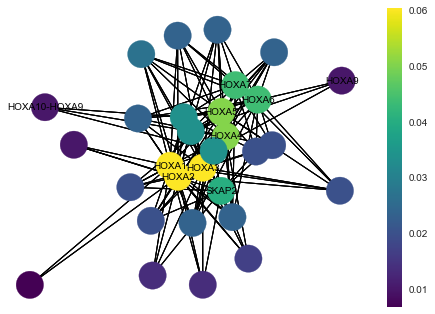

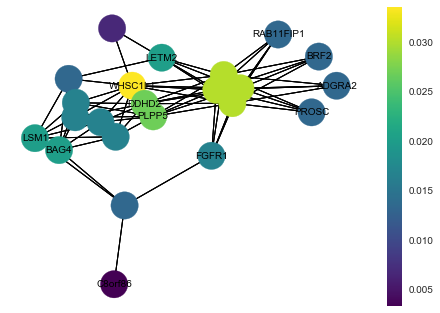

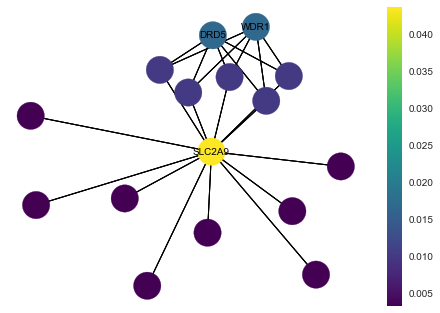

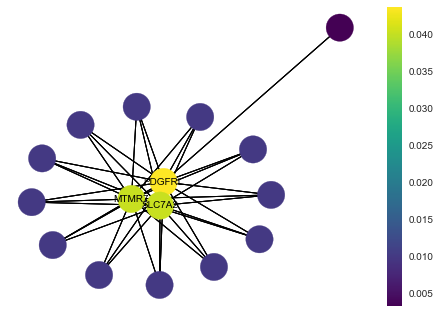

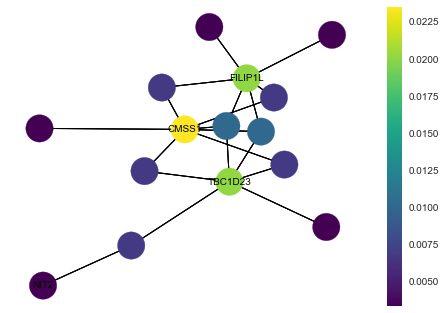

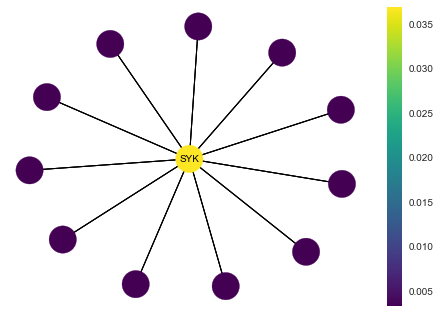

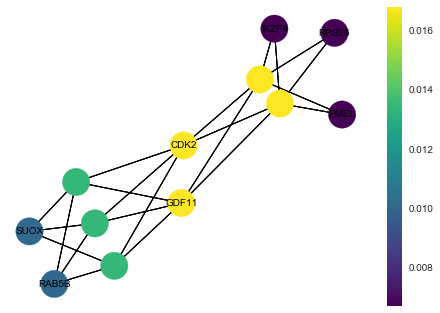

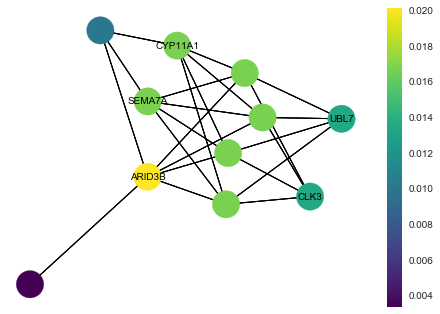

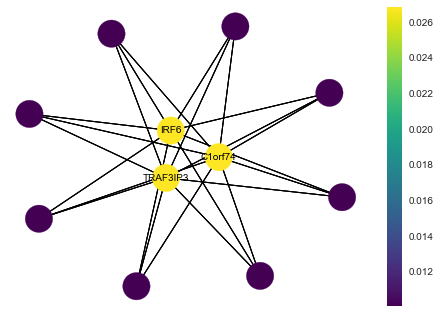

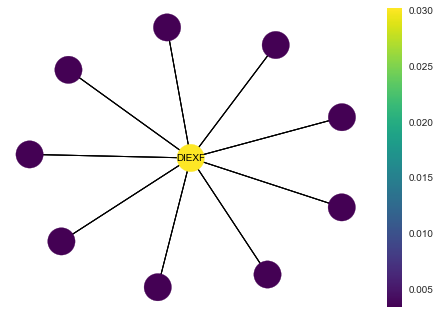

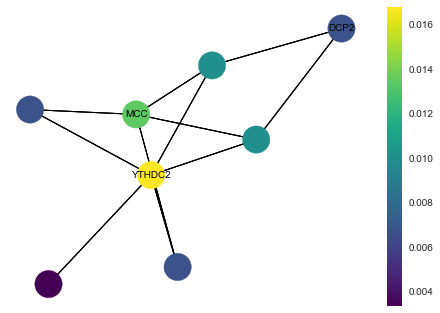

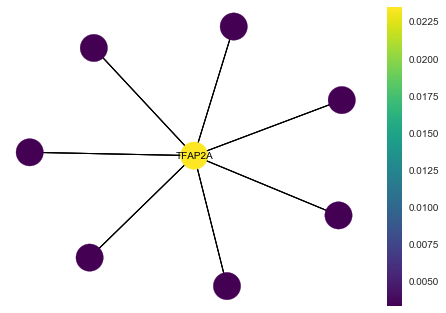

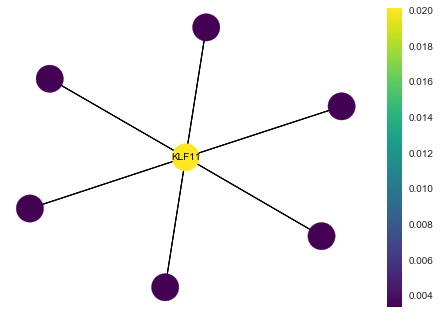

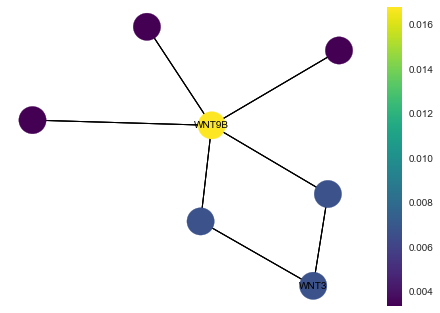

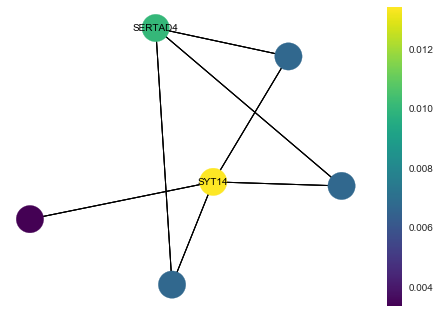

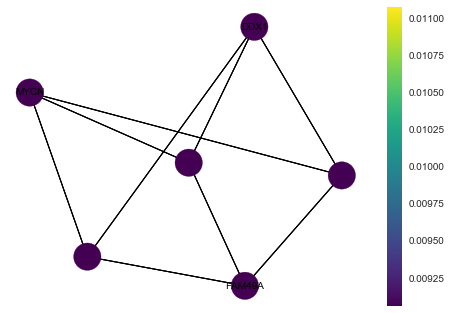

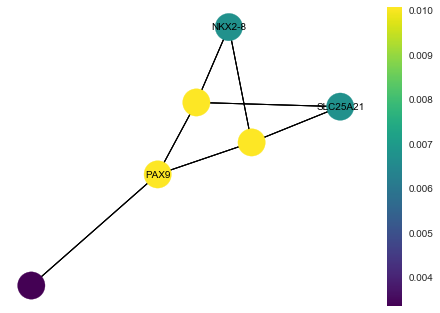

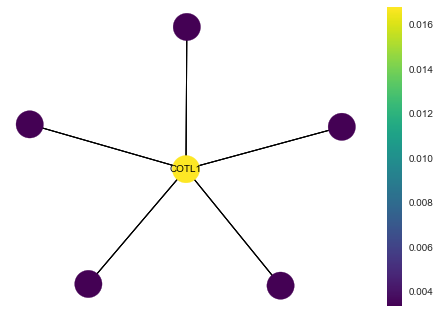

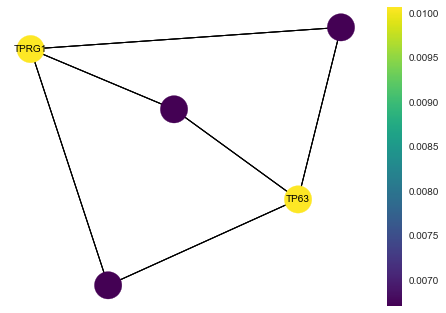

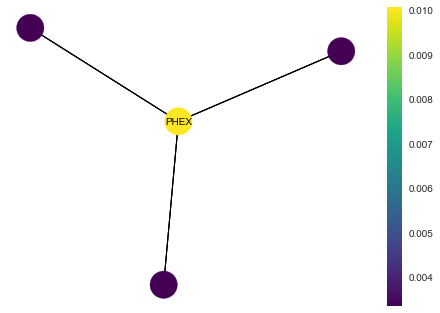

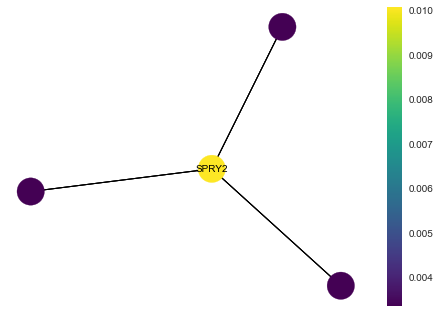

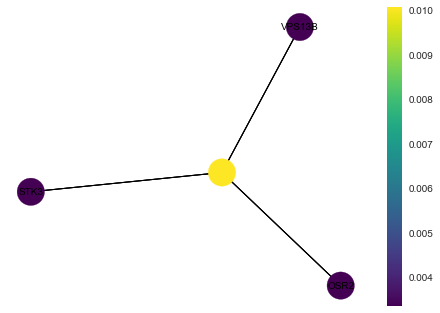

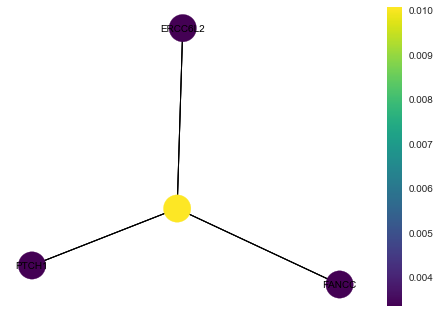

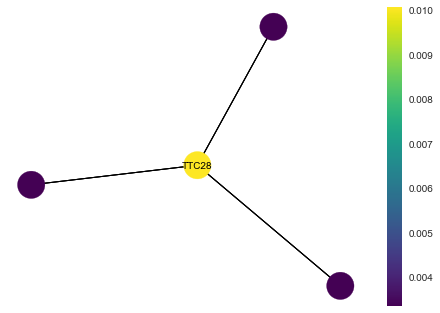

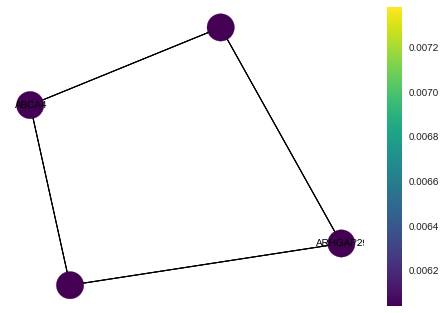

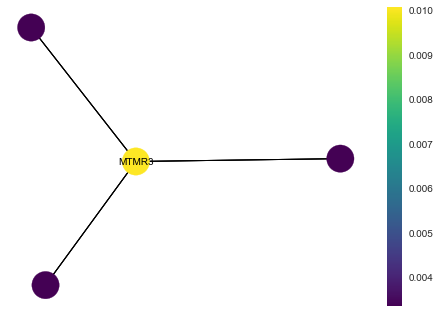

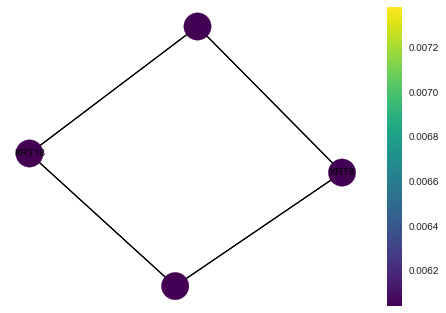

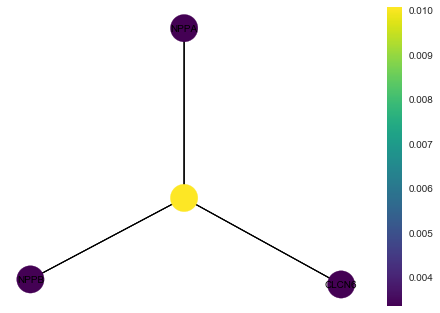

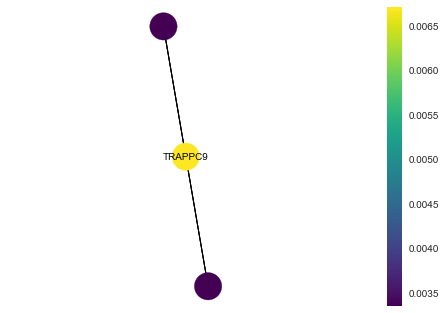

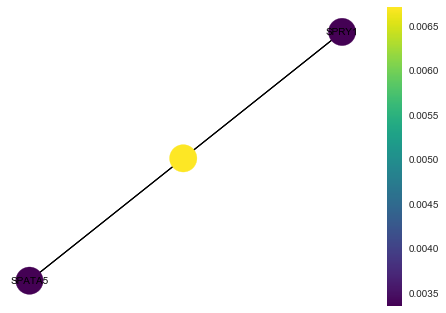

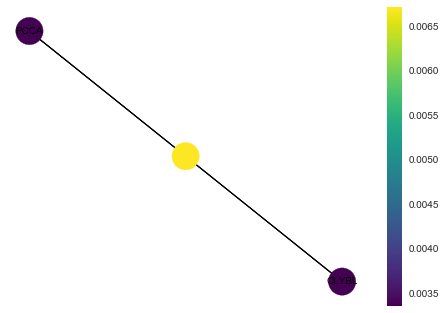

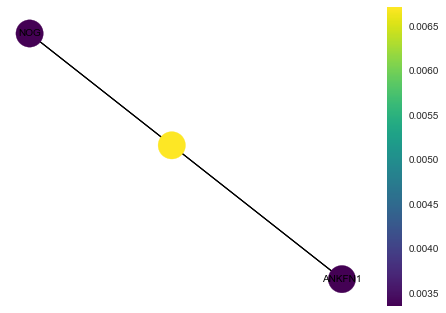

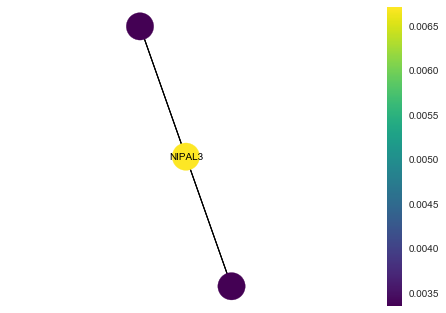

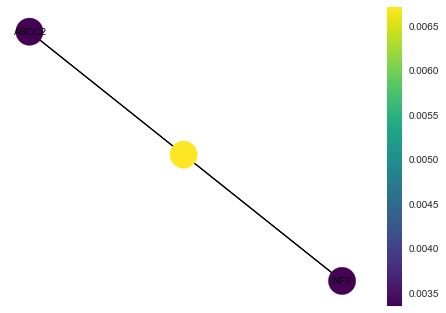

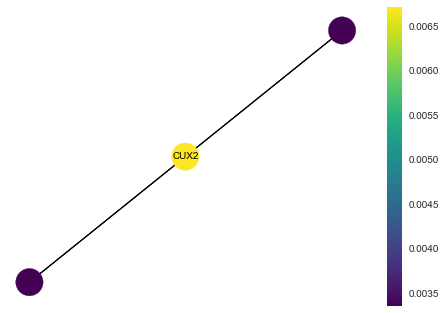

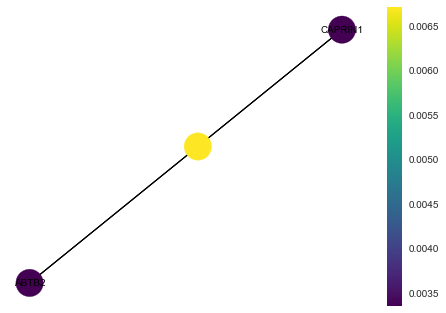

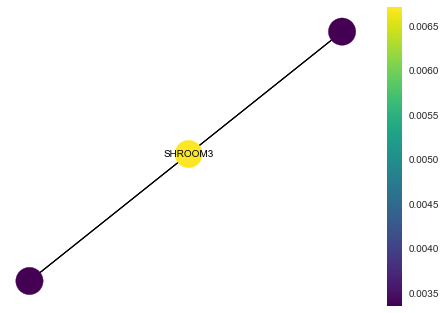

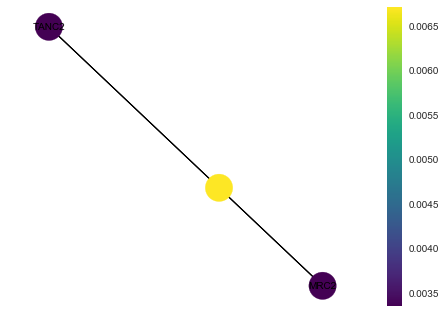

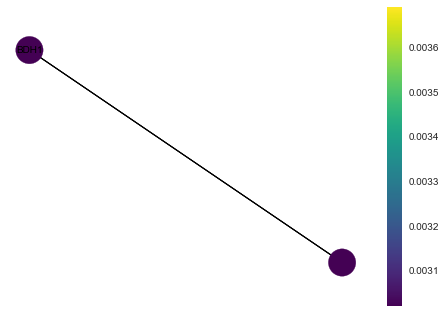

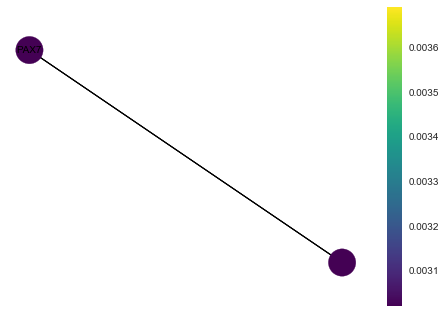

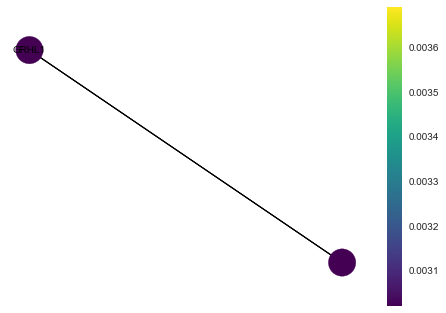

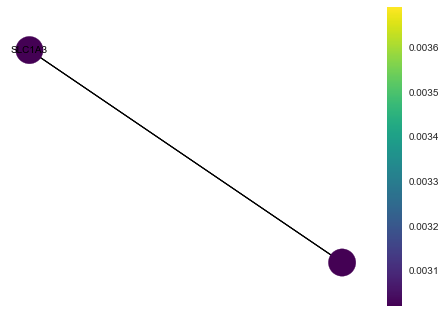

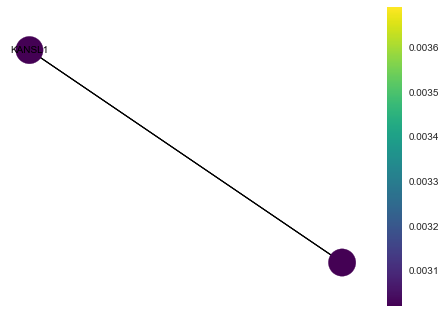

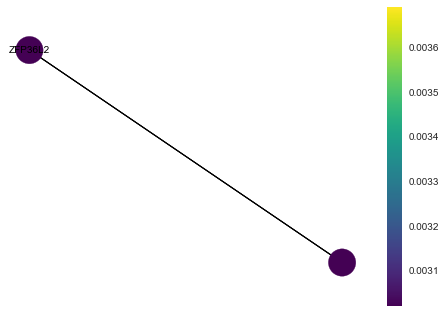

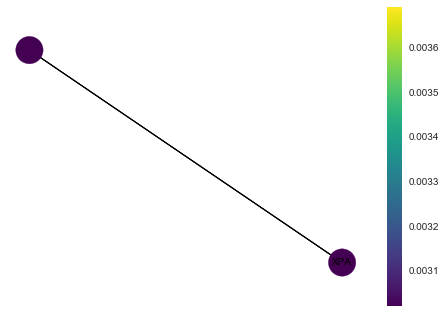

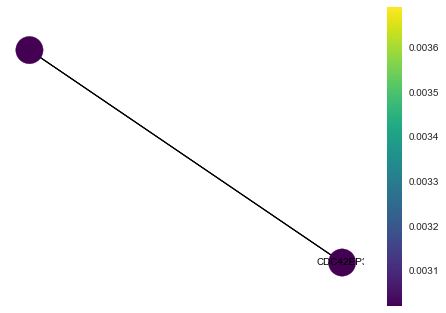

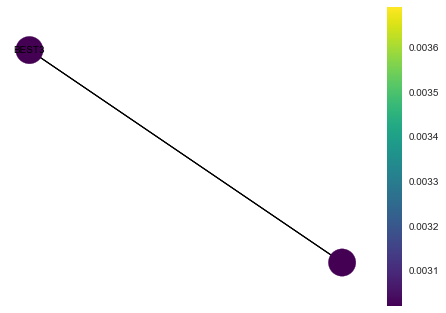

In [ ]:
plotCentrality(G, nx.degree_centrality(G))

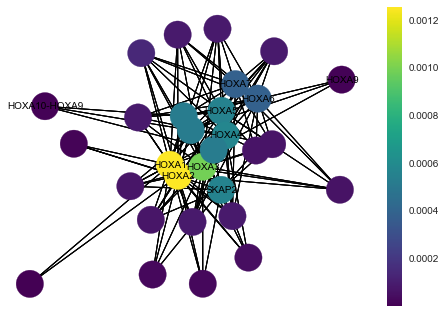

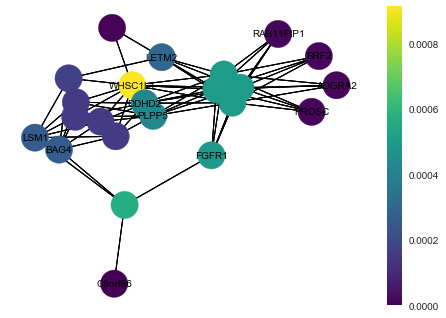

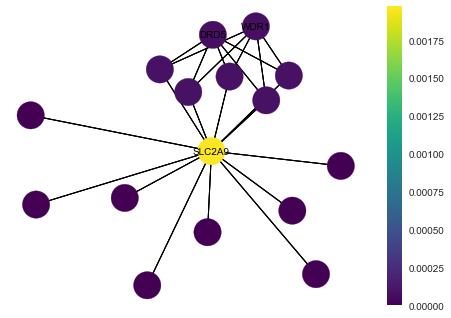

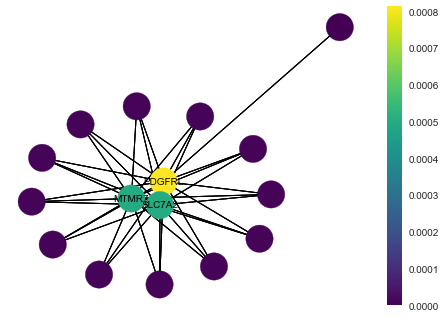

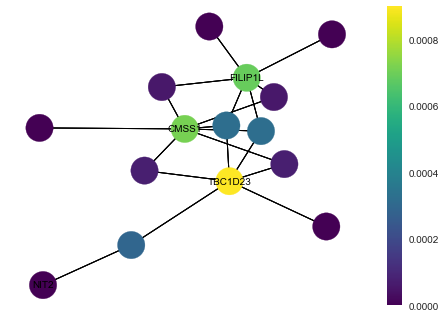

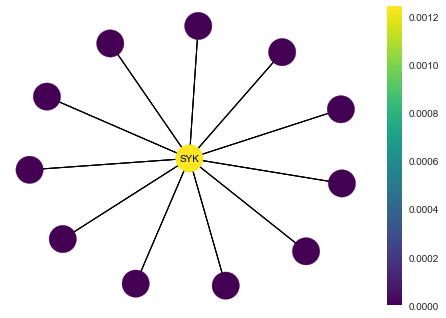

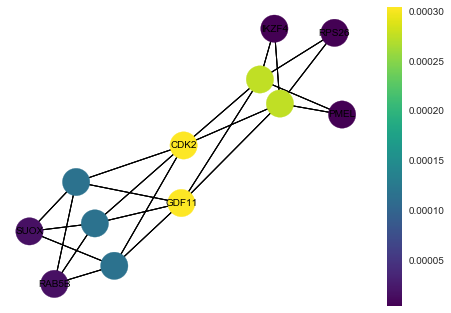

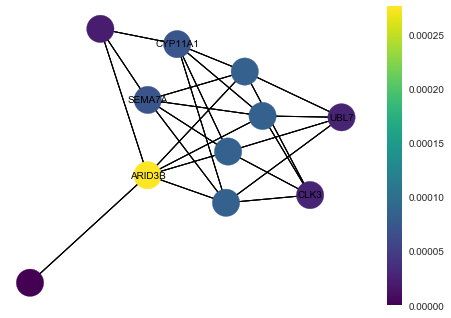

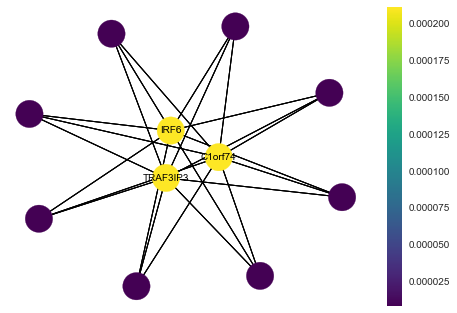

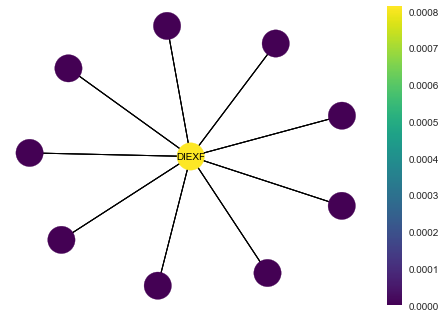

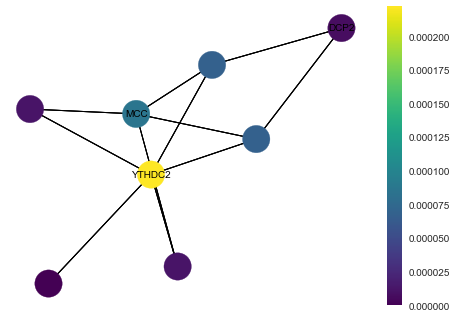

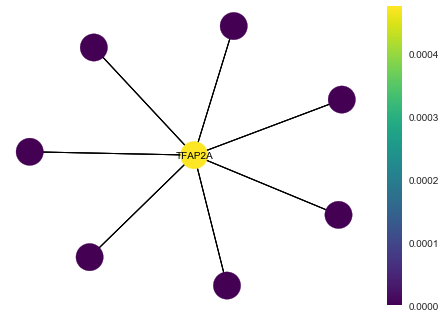

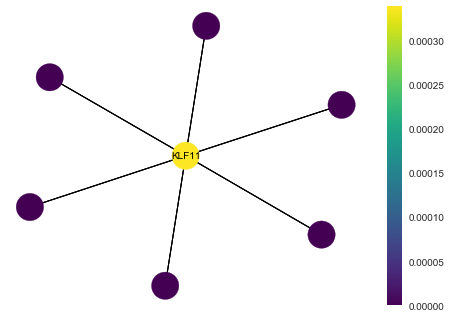

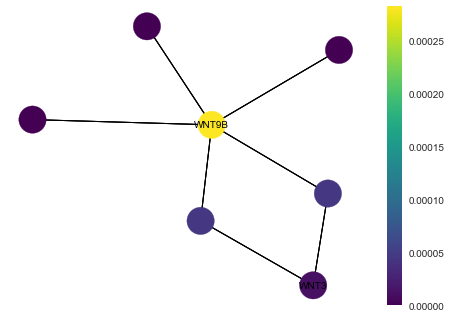

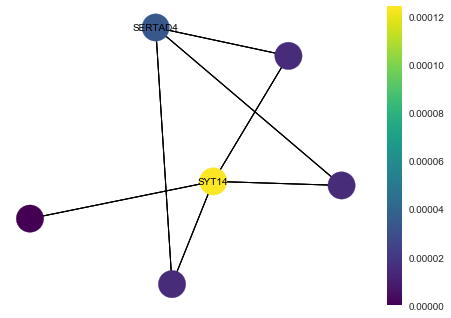

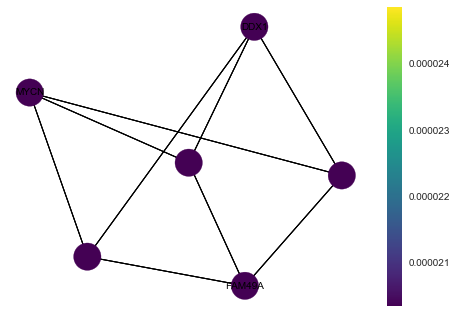

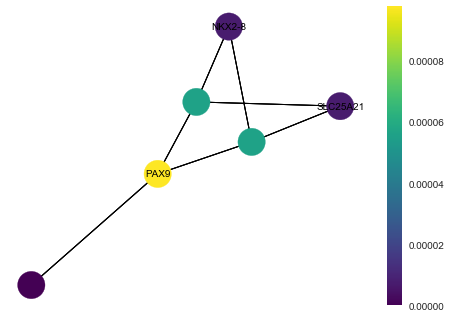

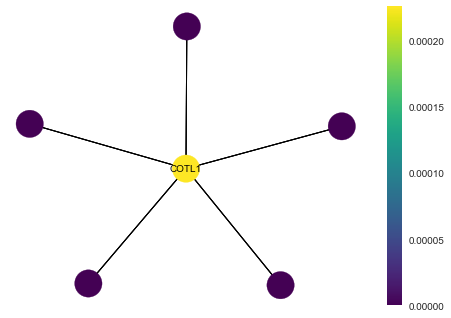

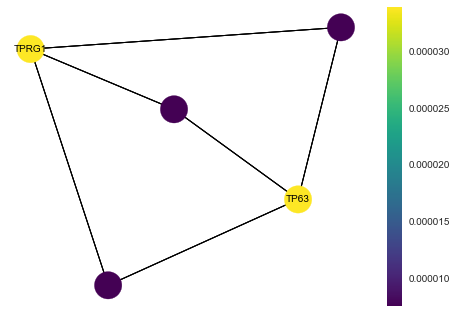

In [ ]:
plotCentrality(G, nx.betweenness_centrality(G))

In [ ]:
plotCentrality(G, nx.eigenvector_centrality(G))

In [ ]:
plotCentrality(G, nx.pagerank(G))

In [ ]:
plus5components = []
for c in sorted(nx.connected_components(G), key=len, reverse=True):
    c = list(c)
    if len(c) >= 5:
        sub_nodes = list(nx.node_connected_component(G, c[0]))
        S = G.subgraph(sub_nodes)
        plus5components.extend(S.nodes())

In [ ]:
ds = [nx.closeness_centrality(G), nx.degree_centrality(G), nx.betweenness_centrality(G)]
#, nx.eigenvector_centrality(G), nx.pagerank(G)]
d = {}
for k in nx.betweenness_centrality(G).keys():
    d[k] = list(d[k] for d in ds)
index = {0:'Closeness Centrality', 1:'Degree Centrality', 2:'Betweenness Centrality'}
#, 3:'Eigenvector Centrality', 4:'Page Rank'}
df = pd.DataFrame.from_dict(d)
df.rename(index=index, inplace=True)
df_limited = df.loc[:, df.columns.str.contains('|'.join(plus5components))]
sns.heatmap(df_limited, cmap=("viridis"))
plt.show()

In [ ]:
ds2 = [nx.closeness_centrality(G), nx.degree_centrality(G), nx.betweenness_centrality(G), nx.eigenvector_centrality(G), nx.pagerank(G)]
d2 = {}
for k in nx.betweenness_centrality(G).keys():
    d2[k] = list(d2[k] for d2 in ds2)
index = {0:'Closeness Centrality', 1:'Degree Centrality', 2:'Betweenness Centrality', 3:'Eigenvector Centrality', 4:'Page Rank'}
df2 = pd.DataFrame.from_dict(d2)
df2.rename(index=index, inplace=True)
sns.heatmap(df2, cmap=("viridis"))
df_limited2 = df2.loc[:, df.columns.str.contains('|'.join(plus5components))]
sns.heatmap(df_limited2, cmap=("viridis"))
plt.show()